# Drug Review Classification: Evaluating the Performance Metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import os
os.getcwd()

'D:\\Python\\Dataset Training\\NLP Project - Drug Review'

We load the preprocessed data:

In [3]:
import pandas as pd
data = pd.read_csv(r'./preprocessed_data.csv')
data.head()

,drugName,condition,review,rating,usefulCount,reviewScrapped
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,27,side effect take combination bystolic mg fish oil
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,192,son halfway fourth week intuniv became concern...
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,17,used take another oral contraceptive pill cycl...
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,10,first time using form birth control glad went ...
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,37,suboxone completely turned life around feel he...


In [4]:
data.shape

(212106, 6)

Convert the text in reviewScrapped into Numeric Values:

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
Review = vectorizer.fit_transform(data['reviewScrapped'].values.astype('str'))
Review.shape

(212106, 44812)

## Filter Contstant Features - Variance Threshold

VarianceThreshold removes all **low-variance features** from the dataset that not useful for ML Models. 

![Constant Features](https://miro.medium.com/max/640/1*xSKlEFsbIV3pgBgoK9GpdA.webp)

<p style="text-align:center"><i> Example: Constant Features [Image Source: Medium] </i> </p>

**WE DROP FEATURES THAT ARE 99.99% SIMILAR**

Threshold: 0.0001 => 0.01%

In [6]:
from sklearn.feature_selection import VarianceThreshold
Review_filter = VarianceThreshold(threshold = 0.0001)
Review_filter.fit(Review)

VarianceThreshold(threshold=0.0001)

In [7]:
Review_filter = Review_filter.transform(Review)

In [8]:
Review_filter.shape

(212106, 1982)

In [9]:
print('Percentage of Features that are constant: ', 1 - (Review_filter.shape[1]/Review.shape[1]))

Percentage of Features that are constant:  0.9557707756850844


Thus, 95.57% of the features are 99.99% similar and do not add value to the classification. We therefore removed them.

We take a subset of the dataset for classification:

In [10]:
Input = Review_filter[:60000]
Input.shape

(60000, 1982)

## Classification 01 - Rating

### Derive Sentiment from Review Rating

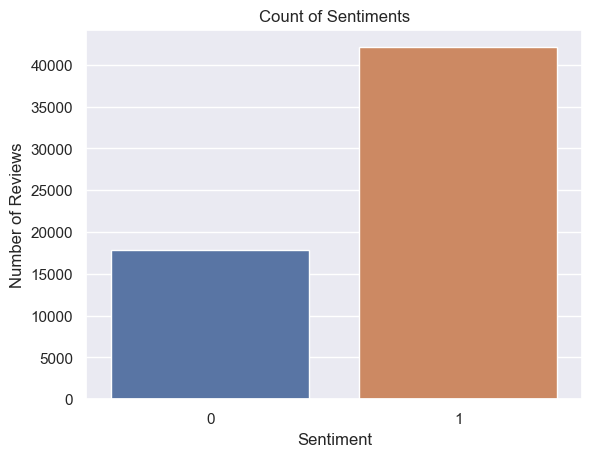

In [11]:
data['Sentiment'] = data['rating'].apply(lambda rating: 1 if rating > 5.0 else 0)
sns.countplot(x = data['Sentiment'][:60000])
plt.ylabel('Number of Reviews')
plt.title('Count of Sentiments')
plt.show()

In [12]:
print('Percentage of positive Sentiments: {:.2f}%'.format(100 * data['Sentiment'][:60000].value_counts()[1]/len(data[:60000])))

Percentage of positive Sentiments: 70.18%


Thus, 70% of the Reviews are positive in nature and only 30% of the reviews are negative. Since the target is unbalanced, we have to cosider the precision and recall. Accuracy alone may not provide us with the complete discription of the model.

In [13]:
Target = data['Sentiment'][:60000]
Target.shape

(60000,)

### Split into Train and Test

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Input, Target, test_size = 0.2, random_state = 42)

In [15]:
print('Shape of Train data: ', x_train.shape, y_train.shape)
print('Shape of Test data: ', x_test.shape, y_test.shape)

Shape of Train data:  (48000, 1982) (48000,)
Shape of Test data:  (12000, 1982) (12000,)


In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### ML Techniques

In [17]:
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, 
                             roc_curve, roc_auc_score,average_precision_score, auc)

#### Multinomial NB

In [18]:
from sklearn.naive_bayes import MultinomialNB

NBClassifier = MultinomialNB().fit(x_train, y_train)
NBClassifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [19]:
y_pred_NB = NBClassifier.predict(x_test)
y_pred_NB_train = NBClassifier.predict(x_train)
print('Accuracy of the train set: ', accuracy_score(y_train, y_pred_NB_train))
print('Accuracy of the test set: ', accuracy_score(y_test, y_pred_NB))

Accuracy of the train set:  0.76125
Accuracy of the test set:  0.75925


Classification Report: 
               precision    recall  f1-score   support

           0       0.58      0.74      0.65      3630
           1       0.87      0.77      0.82      8370

    accuracy                           0.76     12000
   macro avg       0.73      0.75      0.73     12000
weighted avg       0.78      0.76      0.77     12000



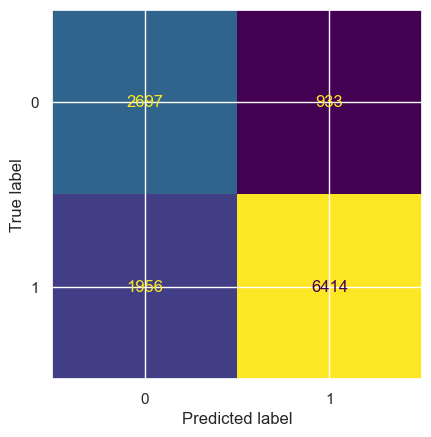

In [20]:
print('Classification Report: \n', classification_report(y_test, y_pred_NB))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_NB, colorbar = False)
plt.show()

#### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegressionCV

LRClassifier = LogisticRegressionCV(max_iter = 500)
LRClassifier.fit(x_train, y_train)
y_pred_LR = LRClassifier.predict(x_test)
y_pred_LR_train = LRClassifier.predict(x_train)
print('Accuracy of the train set: ', accuracy_score(y_train, y_pred_LR_train))
print('Accuracy of the test set: ', accuracy_score(y_test, y_pred_LR))

Accuracy of the train set:  0.8366041666666667
Accuracy of the test set:  0.8233333333333334


Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.59      0.67      3630
           1       0.84      0.93      0.88      8370

    accuracy                           0.82     12000
   macro avg       0.81      0.76      0.77     12000
weighted avg       0.82      0.82      0.82     12000



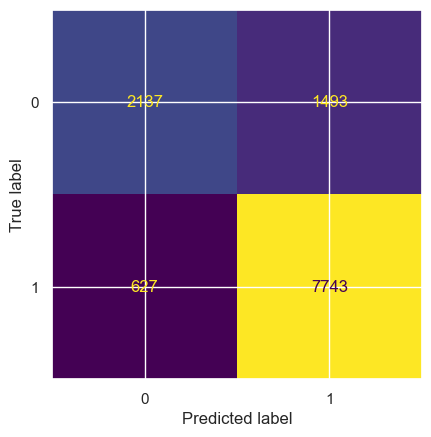

In [22]:
print('Classification Report: \n', classification_report(y_test, y_pred_LR))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_LR, colorbar = False)
plt.show()

#### Extreme Gradient Boosting - XGBoost

In [23]:
from xgboost import XGBClassifier

XGB = XGBClassifier(random_state = 42, max_depth = 15)
XGB.fit(x_train, y_train)
XGB.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 15,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [24]:
y_pred_XGB = XGB.predict(x_test)
y_pred_XGB_train = XGB.predict(x_train)
print('Accuracy of the train set: ', accuracy_score(y_train, y_pred_XGB_train))
print('Accuracy of the test set: ', accuracy_score(y_test, y_pred_XGB))

Accuracy of the train set:  0.9689166666666666
Accuracy of the test set:  0.8318333333333333


Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.59      0.68      3630
           1       0.84      0.94      0.89      8370

    accuracy                           0.83     12000
   macro avg       0.82      0.76      0.78     12000
weighted avg       0.83      0.83      0.82     12000



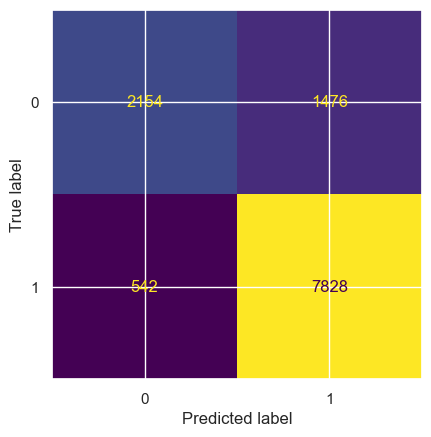

In [25]:
print('Classification Report: \n', classification_report(y_test, y_pred_XGB))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_XGB, colorbar = False)
plt.show()

#### Linear Discriminant Analysis - Dimensionality Reduction

**Supervised algorithm that aims to find the linear discriminants** to represent the axes that:
- Maximise the distance between the two classes and
- Minimize the variance within the individual class

Process:
- Calculate the separability between classes (distance between the mean of different classes): "Between-class variance"
- Calculate the distance between the mean and sample of each class: "Within-class variance"
- Construct the lower-dimensional space which maximizes the between-class variance an  minimizes the within-class variance.

![Principle of LDA](./LDA.png)

<p style="text-align:center"><i> Principle of LDA [Image Source: GeeksForGeeks] </i> </p>

![PCA vs LDA](https://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png)

<p style="text-align:center"><i> PCA vs LDA [Image Source: SebastianRaschka] </i> </p>

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis()
x_train_LDA = LDA.fit_transform(x_train.toarray(), y_train)
x_test_LDA = LDA.fit_transform(x_test.toarray(), y_test)

print('Shape of X_train before LDA: ', x_train.shape, 
      '\nShape of X_test before LDA: ', x_test.shape)
print('Shape of X_train after LDA: ', x_train_LDA.shape,
     '\nShape of X_test after LDA: ', x_test_LDA.shape)

Shape of X_train before LDA:  (48000, 1982) 
Shape of X_test before LDA:  (12000, 1982)
Shape of X_train after LDA:  (48000, 1) 
Shape of X_test after LDA:  (12000, 1)


###### Decision Tree Classifier using Linear Discriminant Analysis

In [27]:
from sklearn.tree import DecisionTreeClassifier

DTClassifier = DecisionTreeClassifier(random_state = 42, max_depth = 15).fit(x_train_LDA, y_train)

In [28]:
y_pred_DT_LDA = DTClassifier.predict(x_test_LDA)
y_pred_DT_LDA_train =DTClassifier.predict(x_train_LDA)
print('Accuracy of the train set: ', accuracy_score(y_train, y_pred_DT_LDA_train))
print('Accuracy of the test set: ', accuracy_score(y_test, y_pred_DT_LDA))

Accuracy of the train set:  0.8617708333333334
Accuracy of the test set:  0.8526666666666667


Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.69      0.74      3630
           1       0.87      0.92      0.90      8370

    accuracy                           0.85     12000
   macro avg       0.83      0.81      0.82     12000
weighted avg       0.85      0.85      0.85     12000



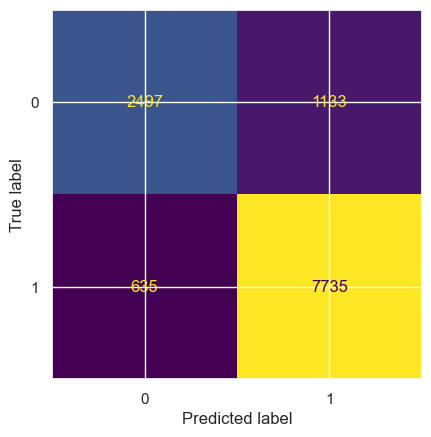

In [29]:
print('Classification Report: \n', classification_report(y_test, y_pred_DT_LDA))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_DT_LDA, colorbar = False)
plt.show()

#### Random Forest using Linear Discriminant Analysis

In [30]:
from sklearn.ensemble import RandomForestClassifier

RFClassifier = RandomForestClassifier(random_state = 42, max_depth = 15).fit(x_train_LDA, y_train)
RFClassifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [31]:
y_pred_RF_LDA = RFClassifier.predict(x_test_LDA)
y_pred_RF_LDA_train = RFClassifier.predict(x_train_LDA)
print('Accuracy of the train set: ', accuracy_score(y_train, y_pred_RF_LDA_train))
print('Accuracy of the test set: ', accuracy_score(y_test, y_pred_RF_LDA))

Accuracy of the train set:  0.8701041666666667
Accuracy of the test set:  0.8633333333333333


Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.72      0.76      3630
           1       0.88      0.93      0.90      8370

    accuracy                           0.86     12000
   macro avg       0.85      0.82      0.83     12000
weighted avg       0.86      0.86      0.86     12000



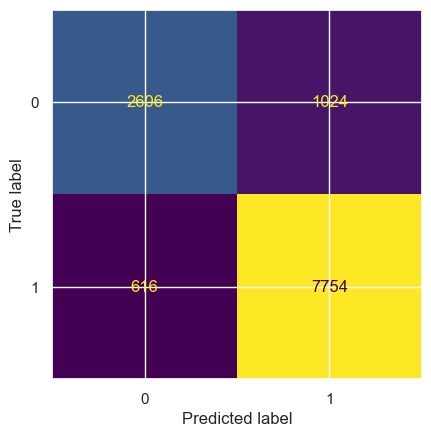

In [32]:
print('Classification Report: \n', classification_report(y_test, y_pred_RF_LDA))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_LDA, colorbar = False)
plt.show()

#### Extreme Gradient Boosting using Linear Discriminant Analysis

In [33]:
XGB_LDA = XGBClassifier(random_state = 42, max_depth = 15)
XGB_LDA.fit(x_train_LDA, y_train)
y_pred_XGB_LDA = XGB_LDA.predict(x_test_LDA)
y_pred_XGB_LDA_train = XGB_LDA.predict(x_train_LDA)
print('Accuracy of the train set: ', accuracy_score(y_train, y_pred_XGB_LDA_train))
print('Accuracy of the test set: ', accuracy_score(y_test, y_pred_XGB_LDA))

Accuracy of the train set:  0.862375
Accuracy of the test set:  0.8615833333333334


Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.72      0.76      3630
           1       0.88      0.93      0.90      8370

    accuracy                           0.86     12000
   macro avg       0.84      0.82      0.83     12000
weighted avg       0.86      0.86      0.86     12000



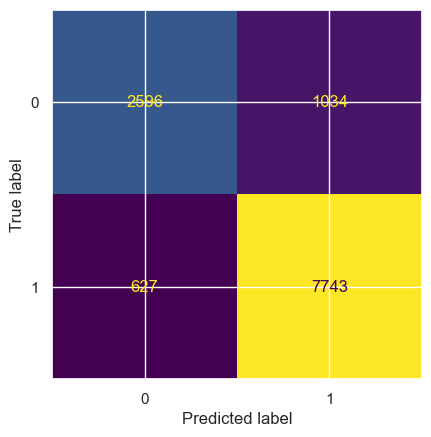

In [34]:
print('Classification Report: \n', classification_report(y_test, y_pred_XGB_LDA))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_XGB_LDA, colorbar = False)
plt.show()

#### ExtraTrees Classifier using Linear Discriminant Analysis

**ExtraTrees Classifiers**
- Similar to Random Forest: Multiple Trees, Split nodes using random subset of features
- No Bootstrapping of Observations => Samples without Replacement
- **Random Splitting of Nodes, Not Best or Optimal Split**

![Extra Trees Classifier](https://miro.medium.com/max/828/1*nijg4NgxkAxM9uHKljfZaQ.webp)

<p style="text-align:center"><i> Random Forest Classifier vs Extra Trees Classifier [Image Source: Medium] </i> </p>

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
ETClassifier = ExtraTreesClassifier(random_state = 42, max_depth = 16)
ETClassifier.fit(x_train_LDA, y_train)
y_pred_ET_LDA = ETClassifier.predict(x_test_LDA)
y_pred_ET_LDA_train = ETClassifier.predict(x_train_LDA)
print('Accuracy of the train set: ', accuracy_score(y_train, y_pred_ET_LDA_train))
print('Accuracy of the test set: ', accuracy_score(y_test, y_pred_ET_LDA))

Accuracy of the train set:  0.8731458333333333
Accuracy of the test set:  0.8664166666666666


Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.73      0.77      3630
           1       0.89      0.93      0.91      8370

    accuracy                           0.87     12000
   macro avg       0.85      0.83      0.84     12000
weighted avg       0.86      0.87      0.86     12000



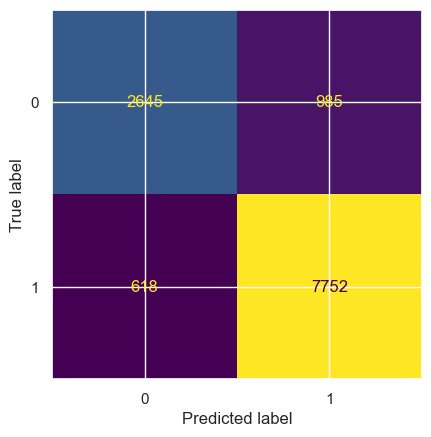

In [36]:
print('Classification Report: \n', classification_report(y_test, y_pred_ET_LDA))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ET_LDA, colorbar = False)
plt.show()

#### Bagging Classifier using Linear Discriminant Analysis

In [37]:
from sklearn.ensemble import BaggingClassifier
BagClassifier = BaggingClassifier(base_estimator = RandomForestClassifier(max_depth = 17), random_state = 42)
BagClassifier.fit(x_train_LDA, y_train)
y_pred_Bag_LDA = BagClassifier.predict(x_test_LDA)
y_pred_Bag_LDA_train = BagClassifier.predict(x_train_LDA)
print('Accuracy of the train set: ', accuracy_score(y_train, y_pred_Bag_LDA_train))
print('Accuracy of the test set: ', accuracy_score(y_test, y_pred_Bag_LDA))

Accuracy of the train set:  0.874375
Accuracy of the test set:  0.8631666666666666


Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.72      0.76      3630
           1       0.88      0.92      0.90      8370

    accuracy                           0.86     12000
   macro avg       0.85      0.82      0.83     12000
weighted avg       0.86      0.86      0.86     12000



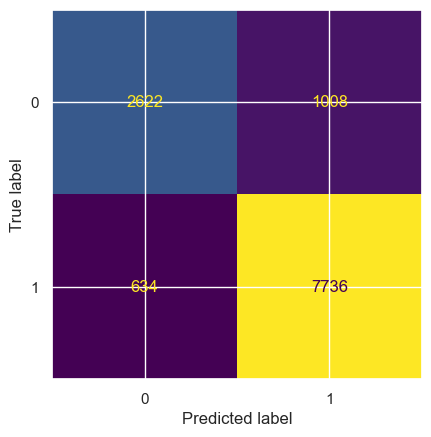

In [38]:
print('Classification Report: \n', classification_report(y_test, y_pred_Bag_LDA))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_Bag_LDA, colorbar = False)
plt.show()

#### Passive Aggressive Classifier using Linear Discriminant Analysis

**Passive Aggressive Classifier**
- Online Learning Algorithm: Handles large datasets and updates weights as new data comes in.
- PASSIVE
    - Correct Classification => No change in weight 
- AGGRESSIVE
    - Incorrect Classification => Minimally update the weights better classification of future samples based on the misclassified sample.


![Passive Aggressive Classifier](./PassiveAggressive.png)

<p style="text-align:center"><i> Passive-Aggressive Algorithm [Image Source: SpeakerDeck] </i> </p>

In [39]:
from sklearn.linear_model import PassiveAggressiveClassifier
PAClassifier = PassiveAggressiveClassifier(random_state = 42, C = 0.6)
PAClassifier.fit(x_train_LDA, y_train)
y_pred_PA_LDA = PAClassifier.predict(x_test_LDA)
y_pred_PA_LDA_train = PAClassifier.predict(x_train_LDA)
print('Accuracy of the train set: ', accuracy_score(y_train, y_pred_PA_LDA_train))
print('Accuracy of the test set: ', accuracy_score(y_test, y_pred_PA_LDA))

Accuracy of the train set:  0.8109791666666667
Accuracy of the test set:  0.84625


Classification Report: 
               precision    recall  f1-score   support

           0       0.70      0.87      0.77      3630
           1       0.94      0.84      0.88      8370

    accuracy                           0.85     12000
   macro avg       0.82      0.85      0.83     12000
weighted avg       0.86      0.85      0.85     12000



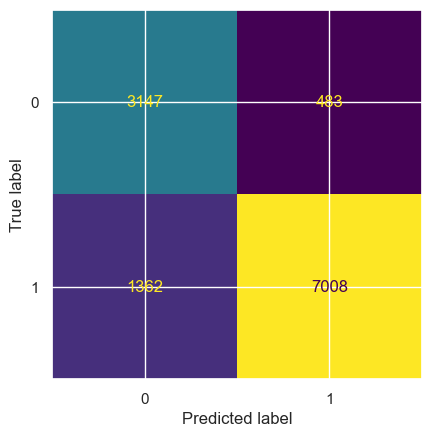

In [40]:
print('Classification Report: \n', classification_report(y_test, y_pred_PA_LDA))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_PA_LDA, colorbar = False)
plt.show()

In [41]:
PAClassifier.get_params()

{'C': 0.6,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'fit_intercept': True,
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### Adaboost Classifier using Linear Discriminant Analysis


![AdaBoost Classifier](https://miro.medium.com/max/828/1*TFnAG7gS1DxdnnBBaBIfFQ.webp)

<p style="text-align:center"><i> General Process: Boosting Algorithms [Image Source: Medium] </i> </p>

In [42]:
from sklearn.ensemble import AdaBoostClassifier
AdaBoost = AdaBoostClassifier(random_state = 42)
AdaBoost.fit(x_train_LDA, y_train)
y_pred_AdaBoost_LDA = AdaBoost.predict(x_test_LDA)
y_pred_AdaBoost_LDA_train = AdaBoost.predict(x_train_LDA)
print('Accuracy of the train set: ', accuracy_score(y_train, y_pred_AdaBoost_LDA_train))
print('Accuracy of the test set: ', accuracy_score(y_test, y_pred_AdaBoost_LDA))

Accuracy of the train set:  0.8327916666666667
Accuracy of the test set:  0.865


Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.79      0.78      3630
           1       0.91      0.90      0.90      8370

    accuracy                           0.86     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.87      0.86      0.87     12000



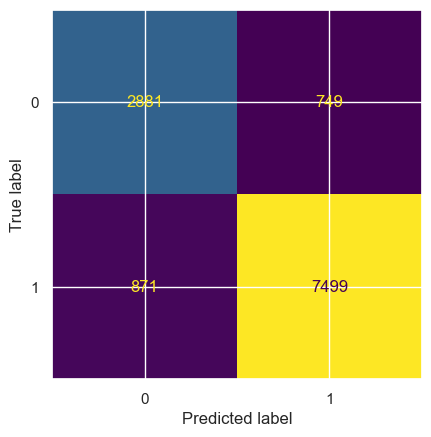

In [43]:
print('Classification Report: \n', classification_report(y_test, y_pred_AdaBoost_LDA))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_AdaBoost_LDA, colorbar = False)
plt.show()

###### GridSearchCV for AdaBoost - Trial 

```r
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import roc_auc_score

    parameters_grid = {
       "algorithm": ['SAMME', 'SAMME.R'],
        "n_estimators": range(50, 500, 50) 
    }

    grid_cv = GridSearchCV(AdaBoost, parameters_grid, scoring="roc_auc", n_jobs=-1, cv=3).fit(x_train_LDA, y_train)
    print("Parameters for Grid Search: ", grid_cv.best_params_)
    print("CV score for Grid Search: ", grid_cv.best_score_)
    print("Train AUC-ROC Score for GS: ", roc_auc_score(y_train, grid_cv.predict(x_train_LDA)))
    print("Test AUC-ROC Score for GS: ", roc_auc_score(y_test, grid_cv.predict(x_test_LDA)))
```

Output:
    
    Parameters for Grid Search:  {'algorithm': 'SAMME.R', 'n_estimators': 150}
    CV score for Grid Search:  0.8900080847705323
    Train AUC-ROC Score for GS:  0.7982342303019385
    Test AUC-ROC Score for GS:  0.8446631515546472


### Accuracy Score

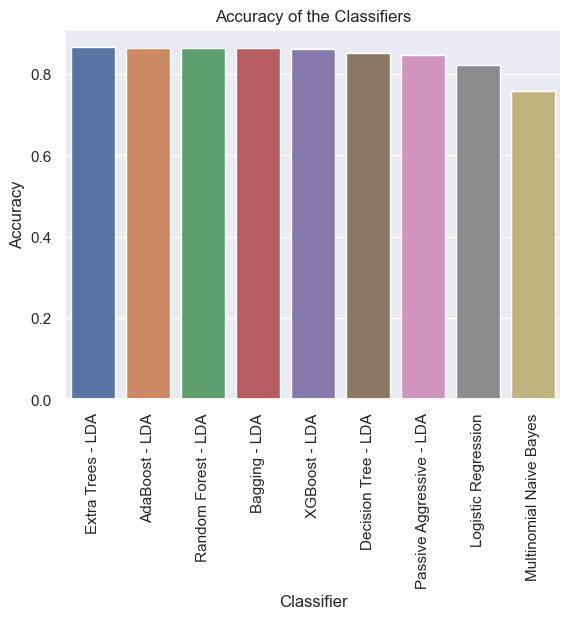

In [44]:
accuracy_df = pd.DataFrame()
accuracy_df['Classifier'] = ['Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest - LDA', 'XGBoost - LDA', 
                             'Extra Trees - LDA', 'Bagging - LDA', 'Passive Aggressive - LDA', 
                             'AdaBoost - LDA', 'Decision Tree - LDA']
accuracy_df['Accuracy'] = [accuracy_score(y_test, y_pred_NB), accuracy_score(y_test, y_pred_LR), 
                            accuracy_score(y_test, y_pred_RF_LDA), accuracy_score(y_test, y_pred_XGB_LDA), 
                            accuracy_score(y_test, y_pred_ET_LDA), accuracy_score(y_test, y_pred_Bag_LDA),
                            accuracy_score(y_test, y_pred_PA_LDA), accuracy_score(y_test, y_pred_AdaBoost_LDA),
                            accuracy_score(y_test, y_pred_DT_LDA)]

sns.barplot(y = 'Accuracy', x = 'Classifier', data = accuracy_df, order = accuracy_df.sort_values('Accuracy', ascending = False).Classifier)
plt.title('Accuracy of the Classifiers')
plt.xticks(rotation=90)
plt.show()

### ROC Curve
#### CHOOSING (POSSIBLY) THE BEST OPTION OF CLASSIFIER FOR CLASSIFICATION OF BAD REVIEWS 

*Plot of False Positive Rate (Inverted Specificity) vs True Positive Rate (Sensitivity)*

$$
TPR = \frac{True Positives}{True Positives + False Negatives}
$$
<p style="text-align:center"> Describes how good the model is at predicting the positive class when the actual outcome is positive [1 predicted as 1]. </p>
$$
FPR = \frac{False Positives}{False Positives + True Negatives} = 1 - Specificity
$$
<p style="text-align:center"> Describes how often a positive class is predicted when the actual outcome is negative [0 predicted as 1]. </p>

##### Considerations
1. **Classifiers within the Early Retrieval Area: Region with the Lowest FPR values or the Highest Specificity values**
2. **Largest Area Under the Curve (AUC) from the No-skill Line**

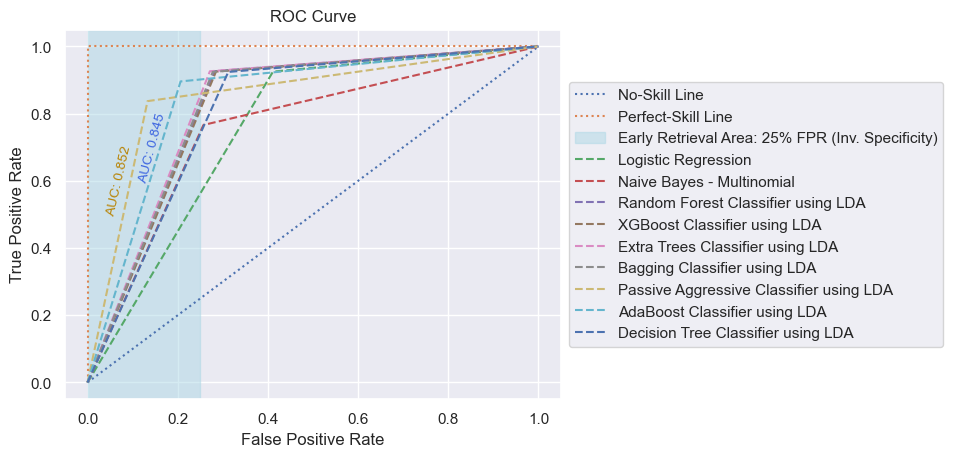

In [45]:
plt.plot([0,1], [0,1], ':', label='No-Skill Line')
plt.plot([0,0, 1],[0,1, 1], ':', label='Perfect-Skill Line')
plt.axvspan(0, 0.25, color = 'lightblue', alpha = 0.5, label='Early Retrieval Area: 25% FPR (Inv. Specificity)')
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_LR)
plt.plot(fpr1, tpr1, '--', label='Logistic Regression')
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_NB)
plt.plot(fpr2, tpr2, '--', label='Naive Bayes - Multinomial')
fpr3, tpr3, thresholds = roc_curve(y_test, y_pred_RF_LDA)
plt.plot(fpr3, tpr3, '--', label='Random Forest Classifier using LDA')
fpr4, tpr4, thresholds = roc_curve(y_test, y_pred_XGB_LDA)
plt.plot(fpr4, tpr4, '--', label='XGBoost Classifier using LDA')
fpr5, tpr5, thresholds = roc_curve(y_test, y_pred_ET_LDA)
plt.plot(fpr5, tpr5, '--', label='Extra Trees Classifier using LDA')
fpr6, tpr6, thresholds = roc_curve(y_test, y_pred_Bag_LDA)
plt.plot(fpr6, tpr6, '--', label='Bagging Classifier using LDA')
fpr7, tpr7, thresholds = roc_curve(y_test, y_pred_PA_LDA)
plt.plot(fpr7, tpr7, '--', label='Passive Aggressive Classifier using LDA')
fpr8, tpr8, thresholds = roc_curve(y_test, y_pred_AdaBoost_LDA)
plt.plot(fpr8, tpr8, '--', label='AdaBoost Classifier using LDA')
fpr8, tpr8, thresholds = roc_curve(y_test, y_pred_DT_LDA)
plt.plot(fpr8, tpr8, '--', label='Decision Tree Classifier using LDA')

from matplotlib.pyplot import text
text(0.04, 0.5, "AUC: " + str(round(roc_auc_score(y_test, y_pred_PA_LDA), 3)), fontsize = 10, 
     rotation = 77, color = "darkgoldenrod")
text(0.11, 0.6, "AUC: " + str(round(roc_auc_score(y_test, y_pred_AdaBoost_LDA), 3)), fontsize = 10, 
     rotation = 75, color = "royalblue", label = "AUC")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(bbox_to_anchor = (1.0, 0.5), loc = 'center left')
plt.show()

In [46]:
aucROC_df = pd.DataFrame()
aucROC_df['Classifier'] = ['Logistic Regression', 'Multinomial Naive Bayes', 'Random Forest - LDA', 'XGBoost - LDA', 
                             'Extra Trees - LDA', 'Bagging - LDA', 'Passive Aggressive - LDA', 
                             'AdaBoost - LDA', 'Decision Tree - LDA']
aucROC_df['AUC: ROC'] = [roc_auc_score(y_test, y_pred_LR), roc_auc_score(y_test, y_pred_NB), 
                         roc_auc_score(y_test, y_pred_RF_LDA), roc_auc_score(y_test, y_pred_XGB_LDA), 
                         roc_auc_score(y_test, y_pred_ET_LDA), roc_auc_score(y_test, y_pred_Bag_LDA),
                         roc_auc_score(y_test, y_pred_PA_LDA), roc_auc_score(y_test, y_pred_AdaBoost_LDA), 
                         roc_auc_score(y_test, y_pred_DT_LDA)]

aucROC_df = aucROC_df.sort_values('AUC: ROC', ascending = False).reset_index(drop = True)
aucROC_df

,Classifier,AUC: ROC
0,Passive Aggressive - LDA,0.852109
1,AdaBoost - LDA,0.844801
2,Extra Trees - LDA,0.827408
3,Bagging - LDA,0.823284
4,Random Forest - LDA,0.822155
5,XGBoost - LDA,0.820121
6,Decision Tree - LDA,0.806006
7,Logistic Regression,0.756897
8,Multinomial Naive Bayes,0.754642


**Passive Aggressive Classifier** is the best option to choose from out of the classifiers that we have implemented, if classifying Bad reviews is the priority.

### Precision - Recall Curve
#### CHOOSING (POSSIBLY) THE BEST OPTION OF CLASSIFIER FOR CLASSIFICATION OF GOOD REVIEWS 

*Plot of Recall (Sensitivity or TPR) vs Precision (Positive Predictive Power)*

$$
Recall = \frac{True Positives}{True Positives + False Negatives}
$$
<p style="text-align:center"> Describes how good the model is at predicting the positive class when the actual outcome is positive [1 predicted as 1]. </p>
$$
Precision = \frac{True Positives}{True Positives + False Positives}
$$
<p style="text-align:center"> Describes how good a model is at predicting the positive class. </p>

$$
No-Skill = \frac{Positives}{Positives + Negatives}
$$

##### Considerations
1. **Classifiers within Area of Highest Recall (predetermined-cutoff): Offers Low False Negatives**
2. **Largest Area Under the Curve (AUC) from the No-skill Line**

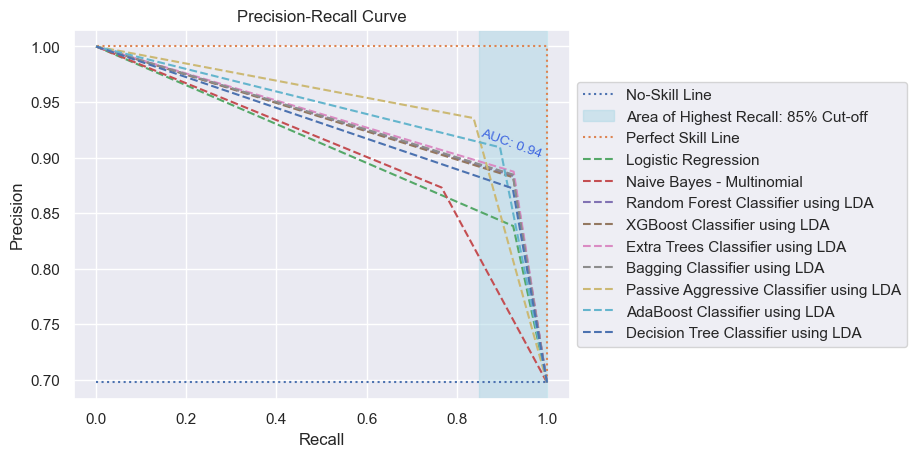

In [47]:
from sklearn.metrics import precision_recall_curve

no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle=':', label='No-Skill Line')
plt.axvspan(0.85, 1, color = 'lightblue', alpha = 0.5, label='Area of Highest Recall: 85% Cut-off')
plt.plot([1, 1, 0],[no_skill, 1, 1], ':', label='Perfect Skill Line')

precision1, recall1, thresholds = precision_recall_curve(y_test, y_pred_LR)
plt.plot(recall1, precision1, '--', label='Logistic Regression')
precision2, recall2, thresholds = precision_recall_curve(y_test, y_pred_NB)
plt.plot(recall2, precision2, '--', label='Naive Bayes - Multinomial')
precision3, recall3, thresholds = precision_recall_curve(y_test, y_pred_RF_LDA)
plt.plot(recall3, precision3, '--', label='Random Forest Classifier using LDA')
precision4, recall4, thresholds = precision_recall_curve(y_test, y_pred_XGB_LDA)
plt.plot(recall4, precision4, '--', label='XGBoost Classifier using LDA')
precision5, recall5, thresholds = precision_recall_curve(y_test, y_pred_ET_LDA)
plt.plot(recall5, precision5, '--', label='Extra Trees Classifier using LDA')
precision6, recall6, thresholds = precision_recall_curve(y_test, y_pred_Bag_LDA)
plt.plot(recall6, precision6, '--', label='Bagging Classifier using LDA')
precision7, recall7, thresholds = precision_recall_curve(y_test, y_pred_PA_LDA)
plt.plot(recall7, precision7, '--', label='Passive Aggressive Classifier using LDA')
precision8, recall8, thresholds = precision_recall_curve(y_test, y_pred_AdaBoost_LDA)
plt.plot(recall8, precision8, '--', label='AdaBoost Classifier using LDA')
precision9, recall9, thresholds = precision_recall_curve(y_test, y_pred_DT_LDA)
plt.plot(recall9, precision9, '--', label='Decision Tree Classifier using LDA')

text(0.85, 0.9, "AUC: " + str(round(auc(recall8, precision8), 2)), fontsize = 10, 
     rotation = -20, color = "royalblue", label = "AUC")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(bbox_to_anchor = (1.0, 0.5), loc = 'center left')
plt.show()

In [48]:
aucPR_df = pd.DataFrame()
aucPR_df['Classifier'] = ['Logistic Regression', 'Multinomial Naive Bayes', 'Random Forest - LDA', 'XGBoost - LDA', 
                             'Extra Trees - LDA', 'Bagging - LDA', 'Passive Aggressive - LDA', 
                             'AdaBoost - LDA', 'Decision Tree - LDA']
aucPR_df['AUC: PR Curve'] = [auc(recall1, precision1), auc(recall2, precision2), auc(recall3, precision3),
                            auc(recall4, precision4), auc(recall5, precision5), auc(recall6, precision6),
                          auc(recall7, precision7), auc(recall8, precision8), auc(recall9, precision9)]

aucPR_df = aucPR_df.sort_values('AUC: PR Curve', ascending = False).reset_index(drop = True)
aucPR_df

,Classifier,AUC: PR Curve
0,Passive Aggressive - LDA,0.943149
1,AdaBoost - LDA,0.938856
2,Extra Trees - LDA,0.932463
3,Bagging - LDA,0.930904
4,Random Forest - LDA,0.930541
5,XGBoost - LDA,0.929766
6,Decision Tree - LDA,0.924644
7,Logistic Regression,0.907845
8,Multinomial Naive Bayes,0.901159


**AdaBoost Classifier** is the best option to choose from out of the classifiers that we have implemented, if classifying Good reviews is our priority.

## Performance Metrics Chart

In [49]:
performance_chart = pd.merge(accuracy_df, aucPR_df, on = "Classifier")
pd.merge(performance_chart,  aucROC_df, on = "Classifier").sort_values("Accuracy", ascending = False)

,Classifier,Accuracy,AUC: PR Curve,AUC: ROC
4,Extra Trees - LDA,0.866417,0.932463,0.827408
7,AdaBoost - LDA,0.865000,0.938856,0.844801
2,Random Forest - LDA,0.863333,0.930541,0.822155
5,Bagging - LDA,0.863167,0.930904,0.823284
3,XGBoost - LDA,0.861583,0.929766,0.820121
8,Decision Tree - LDA,0.852667,0.924644,0.806006
6,Passive Aggressive - LDA,0.846250,0.943149,0.852109
1,Logistic Regression,0.823333,0.907845,0.756897
0,Multinomial Naive Bayes,0.759250,0.901159,0.754642


## Conclusion

* For classifying Good Reviews, AdaBoost Classifier is the best option out of the bunch as determined from the Precision-Recall Curve, whereas for classification of Bad reviews precisely, Passive Aggressive Classifier proves to be an option worth considering, as determined from the ROC.
* Extra Trees have the highest accuracy, followed by AdaBoost and XGBoost.